In [2]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:


# Load mô hình MobileNetV2 đã được huấn luyện trước trên ImageNet
model = models.mobilenet_v2(pretrained=True)

# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Hiển thị kiến trúc mô hình
print(model)


c:\Users\Nguyet\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nguyet\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Đường dẫn đến thư mục TrashNet đã chia train/test
dataset_path = r"D:\temp\pbl\pbl_2025\smart-trash-bin\data\trashnet_split"

# Kích thước ảnh đầu vào của MobileNetV2
IMG_SIZE = 224
BATCH_SIZE = 32

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"❌ Không tìm thấy thư mục dữ liệu: {dataset_path}")

# Tiền xử lý ảnh (chuẩn hóa như ImageNet)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dữ liệu huấn luyện và kiểm tra
train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_dataset = ImageFolder(root=f"{dataset_path}/test", transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Kiểm tra số lượng lớp
num_classes = len(train_dataset.classes)
print(f"Số lớp trong dữ liệu: {num_classes}")


Số lớp trong dữ liệu: 4


In [3]:
# Thay đổi lớp cuối của MobileNetV2
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  # Thêm Dropout với 40% tắt neuron
    nn.Linear(model.last_channel, num_classes)
)
# Chuyển mô hình sang GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Kiểm tra lại kiến trúc mô hình
print(model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# Xác định thiết bị (Chỉ sử dụng CPU)
device = torch.device("cpu")
print(f"✅ Using device: {device}")

# Cấu hình huấn luyện
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Thêm weight decay

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

EPOCHS = 150

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Đánh giá trên tập kiểm tra (Validation)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

print("✅ Huấn luyện hoàn tất!")


✅ Using device: cpu
Epoch 1/150 | Train Loss: 0.8160, Train Acc: 68.68% | Val Loss: 0.6729, Val Acc: 73.70%
Epoch 2/150 | Train Loss: 0.5617, Train Acc: 76.23% | Val Loss: 0.7720, Val Acc: 69.23%
Epoch 3/150 | Train Loss: 0.4856, Train Acc: 82.16% | Val Loss: 0.9994, Val Acc: 72.70%
Epoch 4/150 | Train Loss: 0.5991, Train Acc: 77.17% | Val Loss: 0.6166, Val Acc: 75.93%
Epoch 5/150 | Train Loss: 0.4502, Train Acc: 82.47% | Val Loss: 0.7449, Val Acc: 73.20%
Epoch 6/150 | Train Loss: 0.3840, Train Acc: 86.59% | Val Loss: 0.5676, Val Acc: 81.89%
Epoch 7/150 | Train Loss: 0.3717, Train Acc: 86.40% | Val Loss: 0.5124, Val Acc: 81.64%
Epoch 8/150 | Train Loss: 0.3750, Train Acc: 85.96% | Val Loss: 0.6786, Val Acc: 78.16%
Epoch 9/150 | Train Loss: 0.3836, Train Acc: 85.46% | Val Loss: 0.6928, Val Acc: 78.66%
Epoch 10/150 | Train Loss: 0.3113, Train Acc: 88.33% | Val Loss: 0.7566, Val Acc: 78.41%
Epoch 11/150 | Train Loss: 0.3871, Train Acc: 87.21% | Val Loss: 0.5536, Val Acc: 79.16%
Epoch 12/1

In [5]:
model.eval()  # Chế độ đánh giá
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

val_acc = 100. * correct / total
print(f"Độ chính xác trên tập kiểm tra: {val_acc:.2f}%")


Độ chính xác trên tập kiểm tra: 83.87%


C:\Users\Nguyet\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Nguyet\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


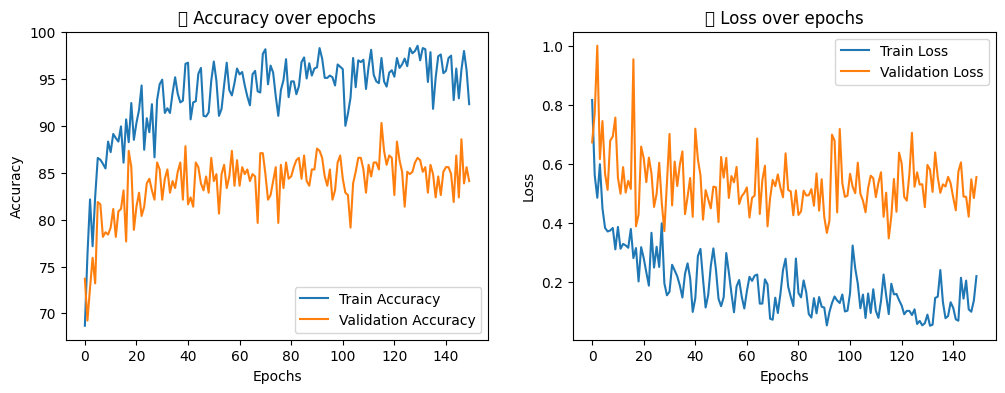

C:\Users\Nguyet\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


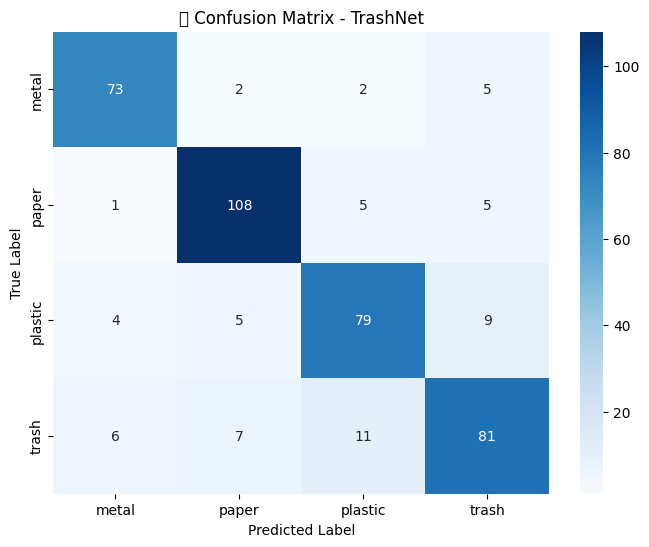

In [6]:
# Vẽ biểu đồ Loss & Accuracy
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('📊 Accuracy over epochs')

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('📉 Loss over epochs')

plt.show()

# Tạo Ma Trận Nhầm Lẫn (Confusion Matrix)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tạo Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_labels = val_dataset.classes  # Lấy tên các lớp từ dataset

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🔍 Confusion Matrix - TrashNet")
plt.show()


In [ ]:
# Lưu mô hình vào máy tính
model_save_path = r"D:\temp\pbl\pbl_2025\smart-trash-bin\AI\mobilenetv2_trashnet_1.pth"
torch.save(model.state_dict(), model_save_path)
print(f"💾 Mô hình đã được lưu tại {model_save_path}")

💾 Mô hình đã được lưu tại D:\temp\pbl\mobilenetv2_trashnet_1.pth


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

num_classes = 4  # Thay bằng số lớp thực tế
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.last_channel, num_classes)
)

# Load trọng số mô hình đã lưu
model_save_path = r"D:\temp\pbl\pbl_2025\smart-trash-bin\AI\mobilenetv2_trashnet_1.pth"
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))

c:\Users\Nguyet\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nguyet\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
new_dataset_path = r"D:\temp\pbl\pbl_2025\smart-trash-bin\data\data_from_esp"
new_dataset = ImageFolder(root=new_dataset_path, transform=transform)
new_loader = DataLoader(new_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()  # Đặt mô hình vào chế độ đánh giá
all_preds = []
all_labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for images, labels in new_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tính độ chính xác trên tập dữ liệu mới
correct = sum(p == l for p, l in zip(all_preds, all_labels))
total = len(all_labels)
new_data_acc = 100. * correct / total
print(f"✅ Độ chính xác trên tập dữ liệu mới: {new_data_acc:.2f}%")



✅ Độ chính xác trên tập dữ liệu mới: 34.60%


In [10]:
new_train_dataset = ImageFolder(root=f"{new_dataset_path}", transform=transform)
new_train_loader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# Xác định thiết bị (Chỉ sử dụng CPU)
device = torch.device("cpu")
print(f"✅ Using device: {device}")

# Cấu hình huấn luyện
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Thêm weight decay

new_train_losses = []
new_train_accuracies = []

EPOCHS = 150

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in new_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    new_train_losses.append(running_loss / len(train_loader))
    new_train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {new_train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}% ")

print("✅ Huấn luyện hoàn tất!")


✅ Using device: cpu
Epoch 1/150 | Train Loss: 0.1518, Train Acc: 59.24% 
Epoch 2/150 | Train Loss: 0.0991, Train Acc: 73.46% 
Epoch 3/150 | Train Loss: 0.0733, Train Acc: 78.67% 
Epoch 4/150 | Train Loss: 0.0717, Train Acc: 77.73% 
Epoch 5/150 | Train Loss: 0.0565, Train Acc: 83.89% 
Epoch 6/150 | Train Loss: 0.0485, Train Acc: 88.63% 
Epoch 7/150 | Train Loss: 0.0384, Train Acc: 91.47% 
Epoch 8/150 | Train Loss: 0.0346, Train Acc: 92.42% 
Epoch 9/150 | Train Loss: 0.0278, Train Acc: 93.84% 
Epoch 10/150 | Train Loss: 0.0281, Train Acc: 94.79% 
Epoch 11/150 | Train Loss: 0.0201, Train Acc: 96.21% 
Epoch 12/150 | Train Loss: 0.0156, Train Acc: 96.21% 
Epoch 13/150 | Train Loss: 0.0207, Train Acc: 94.79% 
Epoch 14/150 | Train Loss: 0.0116, Train Acc: 97.16% 
Epoch 15/150 | Train Loss: 0.0156, Train Acc: 96.21% 
Epoch 16/150 | Train Loss: 0.0116, Train Acc: 98.10% 
Epoch 17/150 | Train Loss: 0.0198, Train Acc: 95.73% 
Epoch 18/150 | Train Loss: 0.0088, Train Acc: 97.63% 
Epoch 19/150 | Tr

In [ ]:

fine_tuned_model_path = r"D:\temp\pbl\pbl_2025\smart-trash-bin\AI\mobilenetv2_trashnet_finetuned.pth"
torch.save(model.state_dict(), fine_tuned_model_path)
print(f"💾 Mô hình đã được lưu tại {fine_tuned_model_path}")

💾 Mô hình đã được lưu tại D:\temp\pbl\mobilenetv2_trashnet_finetuned.pth


In [20]:
# Load lại cả dữ liệu cũ & mới
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, new_train_dataset])
combined_val_dataset = torch.utils.data.ConcatDataset([val_dataset,])

# Tạo DataLoader
combined_train_loader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
combined_val_loader = DataLoader(combined_val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [21]:
EPOCHS_FINE_TUNE = 150
for epoch in range(EPOCHS_FINE_TUNE):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in combined_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS_FINE_TUNE} | Loss: {running_loss / len(combined_train_loader):.4f} | Accuracy: {train_acc:.2f}%")

print("✅ Quá trình fine-tuning kết hợp hoàn tất!")


Epoch 1/150 | Loss: 0.7241 | Accuracy: 79.00%
Epoch 2/150 | Loss: 0.2927 | Accuracy: 89.58%
Epoch 3/150 | Loss: 0.2455 | Accuracy: 91.51%
Epoch 4/150 | Loss: 0.1793 | Accuracy: 93.11%
Epoch 5/150 | Loss: 0.1367 | Accuracy: 94.76%
Epoch 6/150 | Loss: 0.1529 | Accuracy: 94.76%
Epoch 7/150 | Loss: 0.1274 | Accuracy: 95.20%
Epoch 8/150 | Loss: 0.1209 | Accuracy: 95.31%
Epoch 9/150 | Loss: 0.1099 | Accuracy: 96.14%
Epoch 10/150 | Loss: 0.1330 | Accuracy: 95.31%
Epoch 11/150 | Loss: 0.1364 | Accuracy: 95.48%
Epoch 12/150 | Loss: 0.1272 | Accuracy: 95.64%
Epoch 13/150 | Loss: 0.0841 | Accuracy: 97.08%
Epoch 14/150 | Loss: 0.0886 | Accuracy: 96.97%
Epoch 15/150 | Loss: 0.1241 | Accuracy: 95.92%


KeyboardInterrupt: 

In [25]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in new_train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

new_val_acc = 100. * correct / total
print(f"🎯 Độ chính xác trên tập dữ liệu mới: {new_val_acc:.2f}%")


🎯 Độ chính xác trên tập dữ liệu mới: 97.16%


In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

new_val_acc = 100. * correct / total
print(f"🎯 Độ chính xác trên tập train: {new_val_acc:.2f}%")


🎯 Độ chính xác trên tập train: 98.44%


In [27]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

new_val_acc = 100. * correct / total
print(f"🎯 Độ chính xác trên tập test: {new_val_acc:.2f}%")


🎯 Độ chính xác trên tập test: 86.35%


In [ ]:
fine_tuned_model_path = r"D:\temp\pbl\pbl_2025\smart-trash-bin\AI\mobilenetv2_trashnet_combine_finetuned.pth"
torch.save(model.state_dict(), fine_tuned_model_path)
print(f"💾 Mô hình đã được lưu tại {fine_tuned_model_path}")

💾 Mô hình đã được lưu tại D:\temp\pbl\mobilenetv2_trashnet_combine_finetuned.pth
